---
Author: Mustapha Bouhsen <br>
[LinkedIn](https://www.linkedin.com/in/mustapha-bouhsen/)<br>
[Git](https://github.com/mus514)<br>
Date: February 9, 2024<br>
---

# Usefull function for the daily loads

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
from matplotlib import pyplot as plt   #plt.xkcd()
from IPython.display import set_matplotlib_formats
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
from itertools import combinations
from math import pi

from scipy.optimize import minimize

In [0]:
# Setting the matplotlib format to 'retina' for better display quality
set_matplotlib_formats('retina')
plt.style.use('seaborn-notebook')

/root/.ipykernel/1077/command-3996405578401645-4036587617:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Load the data

In [0]:
returns = spark.sql("SELECT * FROM stocks_returns").toPandas()
prices = spark.sql("SELECT * FROM stocks_prices").toPandas()

In [0]:
stocks = ['aapl', 'amzn', 'msft', 'googl']

In [0]:
def garch(theta, r):
    #Extract the parameters
    w = theta[0]
    a = theta[1]
    b = theta[2]
    T = len(r)
    sigma = np.zeros(T+1)
    sigma[0] = np.var(r)

    for i in range(1, T+1):
        sigma[i] = (w+a*(r[i-1]**2)+b*sigma[i-1])

    return sigma

In [0]:
def log_normal_likely(theta, r):
    sigma = garch(theta, r)[:-1]
    ll = (-np.log(np.sqrt(2*pi)*sigma) - 0.5*((r-np.mean(r))/sigma)**2).sum()
    if np.isfinite(ll):
        return ll
    else:
        return 1e10

In [0]:
r = returns["aapl"]

In [0]:
from scipy.optimize import minimize

# Assuming you have some initial guess for theta
initial_guess = [np.var(r), 0.5, 0.4]  # Adjust the initial guess accordingly

# Define a function that returns the negative log-likelihood
neg_log_likelihood = lambda theta: -log_normal_likely(theta, r)


constraint_1 = {'type':'ineq', 'fun':lambda theta: 1-theta[1]-theta[2]}
constraint_2 = {'type':'ineq', 'fun':lambda theta: theta[1]-1}
constraint_3 = {'type':'ineq', 'fun':lambda theta: theta[2]-1}

bonds = [(0, np.var(r)), (0.0001, 0.99), (0.0001, 0.99)]

constraints = [constraint_1, constraint_2, constraint_3]

#bounds = [(0, 1), (0, 1), (0, 1)]
# Use the minimize function with the constraints
result = minimize(neg_log_likelihood, initial_guess, constraints=constraints, )

# Extract the optimal parameters
optimal_theta = result.x

# Print the results
print("Optimal Parameters:", optimal_theta)

/root/.ipykernel/1077/command-3996405578401649-3861306153:11: RuntimeWarning: overflow encountered in double_scalars
  sigma[i] = (w+a*(r[i-1]**2)+b*sigma[i-1])
/root/.ipykernel/1077/command-3575624524394449-7180763:3: RuntimeWarning: invalid value encountered in log
  ll = (-np.log(np.sqrt(2*pi)*sigma) - 0.5*((r-np.mean(r))/sigma)**2).sum()
/root/.ipykernel/1077/command-3575624524394449-7180763:3: RuntimeWarning: overflow encountered in multiply
  ll = (-np.log(np.sqrt(2*pi)*sigma) - 0.5*((r-np.mean(r))/sigma)**2).sum()
/root/.ipykernel/1077/command-3996405578401649-3861306153:11: RuntimeWarning: overflow encountered in double_scalars
  sigma[i] = (w+a*(r[i-1]**2)+b*sigma[i-1])
/root/.ipykernel/1077/command-3575624524394449-7180763:3: RuntimeWarning: overflow encountered in multiply
  ll = (-np.log(np.sqrt(2*pi)*sigma) - 0.5*((r-np.mean(r))/sigma)**2).sum()
/root/.ipykernel/1077/command-3575624524394449-7180763:3: RuntimeWarning: invalid value encountered in log
  ll = (-np.log(np.sqr

In [0]:
sigma = garch(optimal_theta, r)

<AxesSubplot:>

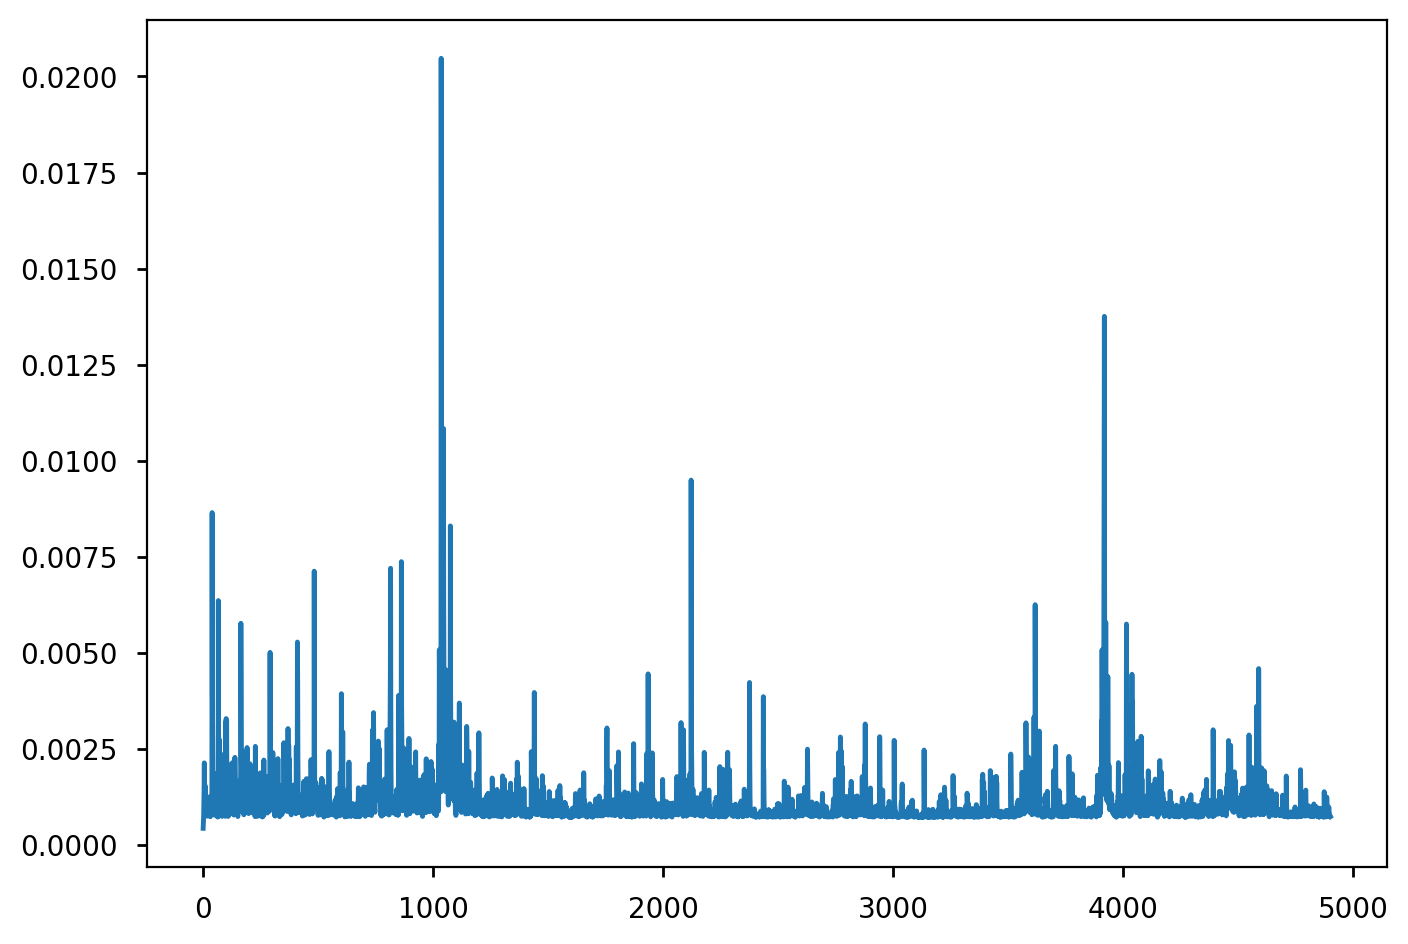

In [0]:
sns.lineplot(y=sigma, x = range(0, len(sigma)))

In [0]:
r

0       0.002926
1       0.009050
2       0.027608
3       0.033850
4       0.047565
          ...   
4897    0.009799
4898    0.008595
4899    0.000581
4900   -0.005771
4901    0.004086
Name: aapl, Length: 4902, dtype: float64